In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz
import gluonts

In [2]:
data_path = "./data/"
data_freq = "H"
patience = 10
learning_rate = 0.0001

start_train_date = datetime(2017, 1, 1)
end_train_date = datetime(2018, 12, 31)
test_date = datetime(2019, 1, 1)
nb_hours_pred = 2*7*24

In [3]:
df = pd.read_csv(data_path + "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"],
                usecols=["Région", "Date - Heure", "Consommation (MW)"]).sort_values(
    by=["Région", "Date - Heure"])

In [4]:
df.rename(columns={"Date - Heure": "Date"}, inplace=True)
df.fillna(df.dropna()["Consommation (MW)"].mean(), inplace=True)
df["date_heure"] = df["Date"].apply(lambda x: x + timedelta(minutes=x.minute))
df["date_heure"] = df["date_heure"].apply(lambda x: x.astimezone(tz("UTC")))
df["date_heure"] = df["date_heure"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df.head(3)

,Région,Date,Consommation (MW),date_heure
1288256,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
1288257,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
116935,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00


In [5]:
df_hour = df.groupby(["Région", "date_heure"], as_index=False).agg({"Consommation (MW)": np.sum})
df_hour.head(3)

,Région,date_heure,Consommation (MW)
0,Auvergne-Rhône-Alpes,2013-01-01 00:00:00,4528.493194
1,Auvergne-Rhône-Alpes,2013-01-01 01:00:00,16117.000000
2,Auvergne-Rhône-Alpes,2013-01-01 02:00:00,15778.000000


In [10]:
df_dict = {}

for region in pd.unique(df_hour["Région"]):
    df_dict[region] = df_hour[df_hour["Région"]==region].copy().reset_index(drop=True)
    df_dict[region].index = df_dict[region]["date_heure"]
    df_dict[region] = df_dict[region].reindex(
        pd.date_range(start=df_hour["date_heure"].min(), end=df_hour["date_heure"].max(), freq=data_freq)).drop(
        ["date_heure", "Région"], axis=1)

# Fonctions pour entraînement DeepAR

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, target_col, max_epochs, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, target_col, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots, figname):
    label_fontsize = 16
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id]["Consommation (MW)"][
            test_date + timedelta(hours=1):test_date + timedelta(hours=nb_hours_pred)].values
        MAPE = np.mean(np.apply_along_axis(abs, 0, (ground_truth - results_mean) / ground_truth))
        plt.title(forecast.item_id + " MAPE:{}%".format(str(round(100*MAPE, 1))))
        plt.ylabel("Consumption (MW)")
        plt.xlabel("")
        ax.set_xlim([test_date - timedelta(days=nb_hours_pred/24), test_date + timedelta(days=nb_hours_pred/24)])
        ax.set_ylim([12000, 28000])
        xticks = [test_date + timedelta(days=x) for x in [-11, -7, -3, 0, 4, 8, 12]]
        ax.set_xticks(xticks, minor=True)
        ax.set_xticklabels([datetime.strftime(date, "%Y-%m-%d") for date in xticks if date != test_date],
                           minor=True, fontsize=label_fontsize)
        ax.set_xticklabels(["", datetime.strftime(test_date, "%Y-%m-%d"), ""], minor=False,
                           fontsize=label_fontsize)
        yticks = np.arange(14000, 28000, step=2000)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(x) for x in yticks], fontsize=label_fontsize)
        plt.savefig(figname)
        plt.show()
    
    return MAPE

# Test Île de France

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.33it/s, avg_epoch_loss=10.2]
INFO:root:Epoch[0] Elapsed time 37.524 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.224716
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.32]
INFO:root:Epoch[1] Elapsed time 33.069 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.317731
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=8.81]
INFO:root:Epoch[2] Elapsed time 32.664 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.811611
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=8.5] 
INFO:root:Epoch[3] Elapsed time 32.728 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.502019
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.215078
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[37] Elapsed time 32.723 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.159488
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[38] Elapsed time 32.698 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.163344
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[39] Elapsed time 32.701 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.165741
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[40] Elapsed time 32.502 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.141045
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.55it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[74] Elapsed time 32.188 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.960887
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[75] Elapsed time 32.574 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.952607
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.55it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[76] Elapsed time 32.247 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.940034
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[77] Elapsed time 32.949 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.943704
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.92]
INF

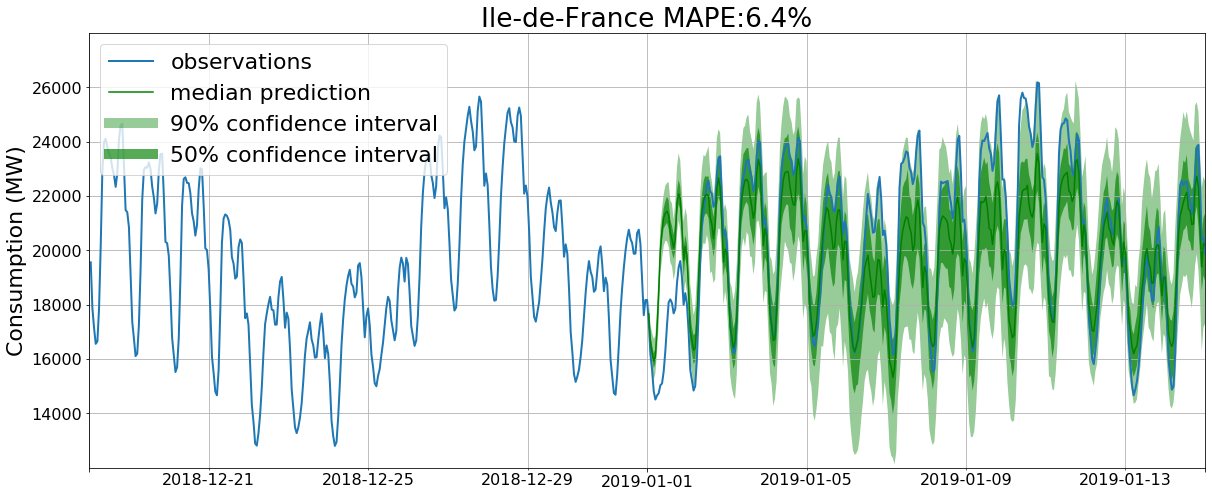

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.35it/s, avg_epoch_loss=11.5]
INFO:root:Epoch[0] Elapsed time 36.994 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.521809
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=10.1]
INFO:root:Epoch[1] Elapsed time 32.786 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=10.119618
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=9.61]
INFO:root:Epoch[2] Elapsed time 32.565 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.613632
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=9.07]
INFO:root:Epoch[3] Elapsed time 32.701 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=9.066145
INFO:root:Ep

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.285146
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.3] 
INFO:root:Epoch[37] Elapsed time 33.246 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.303590
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 32.686 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.270606
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[39] Elapsed time 32.934 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.272552
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[40] Elapsed time 32.894 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.258002
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[74] Elapsed time 32.846 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.976803
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.55it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[75] Elapsed time 32.214 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.987336
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.56it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[76] Elapsed time 32.130 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.988105
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 32.680 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.948310
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=6.98]
INF

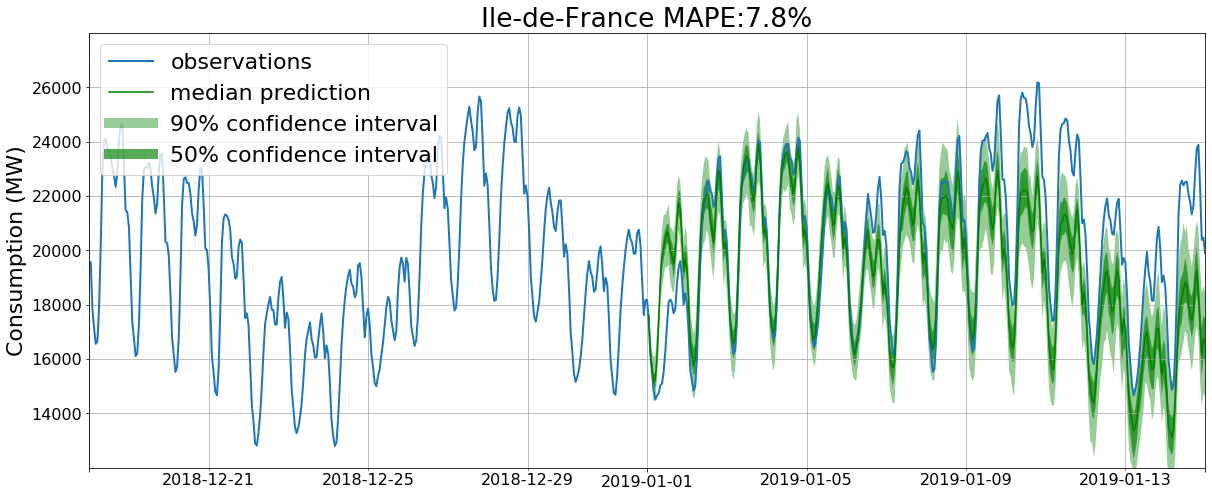

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.35it/s, avg_epoch_loss=10.7]
INFO:root:Epoch[0] Elapsed time 37.002 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.653590
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=9.53]
INFO:root:Epoch[1] Elapsed time 32.506 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.527567
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.99]
INFO:root:Epoch[2] Elapsed time 32.966 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.988822
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=8.71]
INFO:root:Epoch[3] Elapsed time 32.440 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.712436
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.254058
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[37] Elapsed time 32.560 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.250959
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[38] Elapsed time 32.827 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.234789
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[39] Elapsed time 32.833 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.217997
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[40] Elapsed time 32.977 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.213324
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[74] Elapsed time 32.535 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.987953
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[75] Elapsed time 32.775 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.976012
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[76] Elapsed time 32.574 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.971379
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[77] Elapsed time 33.126 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.960129
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=6.94]
INF

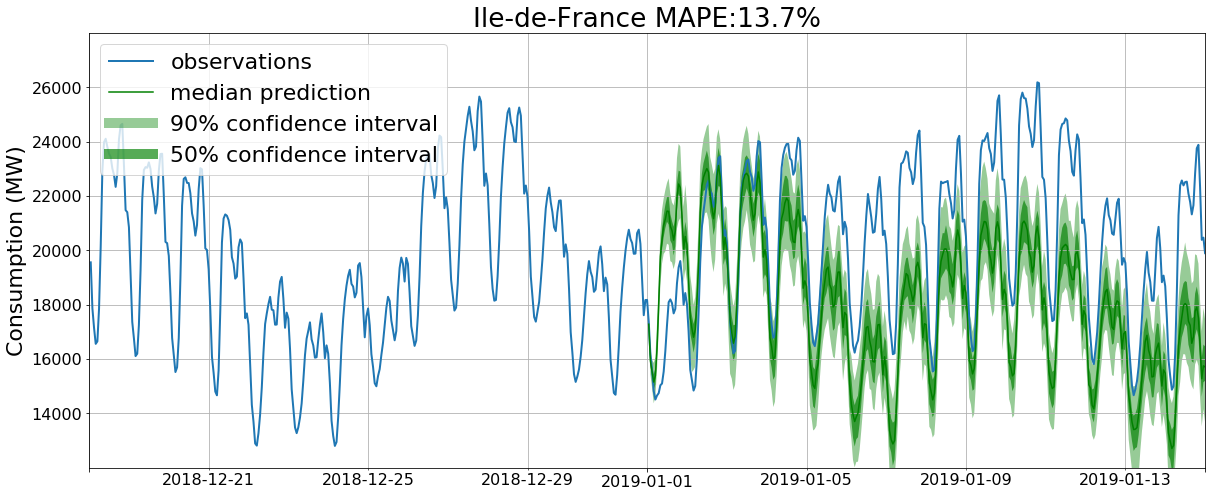

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:36<00:00,  1.35it/s, avg_epoch_loss=10.3]
INFO:root:Epoch[0] Elapsed time 36.972 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.324136
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=9.34]
INFO:root:Epoch[1] Elapsed time 33.083 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.341188
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=8.92]
INFO:root:Epoch[2] Elapsed time 32.805 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.918746
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.54it/s, avg_epoch_loss=8.57]
INFO:root:Epoch[3] Elapsed time 32.437 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.568293
INFO:root:Epo

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.292507
INFO:root:Epoch[37] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.55it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[37] Elapsed time 32.182 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.281824
INFO:root:Epoch[38] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.55it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 32.268 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.270901
INFO:root:Epoch[39] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.56it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 32.089 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.262939
INFO:root:Epoch[40] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.53it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[40] Elapsed time 32.608 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.249837
INFO:root:Epoch[41] Learning rate is 0.0001
100%|███████

INFO:root:Epoch[74] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.50it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[74] Elapsed time 33.242 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.018911
INFO:root:Epoch[75] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[75] Elapsed time 33.467 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.017282
INFO:root:Epoch[76] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[76] Elapsed time 33.156 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.028882
INFO:root:Epoch[77] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.49it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[77] Elapsed time 33.572 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.022313
INFO:root:Epoch[78] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=7.01]
INF

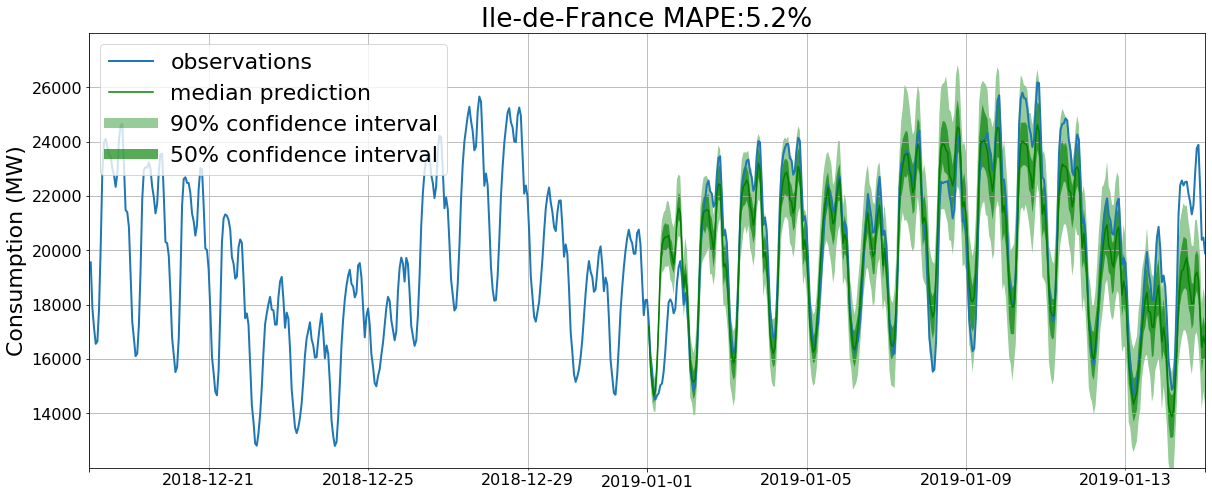

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:37<00:00,  1.32it/s, avg_epoch_loss=11.1]
INFO:root:Epoch[0] Elapsed time 37.916 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.100730
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.8] 
INFO:root:Epoch[1] Elapsed time 32.839 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.796413
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:32<00:00,  1.52it/s, avg_epoch_loss=9.11]
INFO:root:Epoch[2] Elapsed time 32.874 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.112458
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:33<00:00,  1.51it/s, avg_epoch_loss=8.55]
INFO:root:Epoch[3] Elapsed time 33.186 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.552578
INFO:root:Epo

In [ ]:
idf_list = ["Ile-de-France"]

for i in range(5):
    for max_epochs in [80]:
        idf_predictor = train_predictor(df_dict, end_train_date, idf_list, max_epochs=max_epochs,
                                        target_col="Consommation (MW)", feat_dynamic_cols=None)
        
        matplotlib.rcParams.update({'font.size': 22})
        forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list,
                                          target_col="Consommation (MW)")
        MAPE = plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1,
                       figname="./deepar_stability_study/figures/{}_epochs_trial_{}.png".format(max_epochs, i+1))
        
        result_df = pd.DataFrame.from_records([{"max_epochs": max_epochs, "MAPE": MAPE, "trial_nb": i+1}])
        
        try:
            existing_results = pd.read_csv("./deepar_stability_study/results.csv")
        except:
            existing_results = None
        
        final_results = pd.concat([existing_results, result_df])
        
        final_results.to_csv("./deepar_stability_study/results.csv", index=False)
        